# Project: Deep Learning: Image Classification using CNN and Transfer Learning

In [1]:
# Imports

import sys
import os
from pathlib import Path
print(sys.executable)

# Ensure project root is on sys.path so `utils` can be imported
cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    project_root = cwd.parent
elif cwd.name.lower() == "cifar10_project":
    project_root = cwd
elif (cwd / "cifar10_project").is_dir():
    project_root = cwd / "cifar10_project"
else:
    project_root = None

if project_root is not None and str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10  # built-in CIFAR-10 loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from utils.ml_utils import normalize_splits

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(
    "ignore",
    category=np.exceptions.VisibleDeprecationWarning
)


/home/user/venvs/cifar10-gpu/bin/python


2026-02-21 02:17:06.689310: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-21 02:17:06.947242: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-21 02:17:07.736353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load and split the dataset (40k / 10k / 10k)

# Load CIFAR-10
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

print("Train full:", x_train_full.shape, y_train_full.shape)
print("Test:", x_test.shape, y_test.shape)

# Train/validation split from the 50k training images
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full,
    y_train_full,
    test_size=0.2,      # 20% of 50k = 10k for validation
    random_state=42,
    stratify=y_train_full,
)

print("Train:", x_train.shape, y_train.shape)
print("Val:", x_val.shape, y_val.shape)
print("Test:", x_test.shape, y_test.shape)


Train full: (50000, 32, 32, 3) (50000, 1)
Test: (10000, 32, 32, 3) (10000, 1)
Train: (40000, 32, 32, 3) (40000, 1)
Val: (10000, 32, 32, 3) (10000, 1)
Test: (10000, 32, 32, 3) (10000, 1)


In [3]:
# Normalize images using reusable utility
splits = normalize_splits({
    "train": x_train,
    "val": x_val,
    "test": x_test,
})

x_train = splits["train"]
x_val = splits["val"]
x_test = splits["test"]

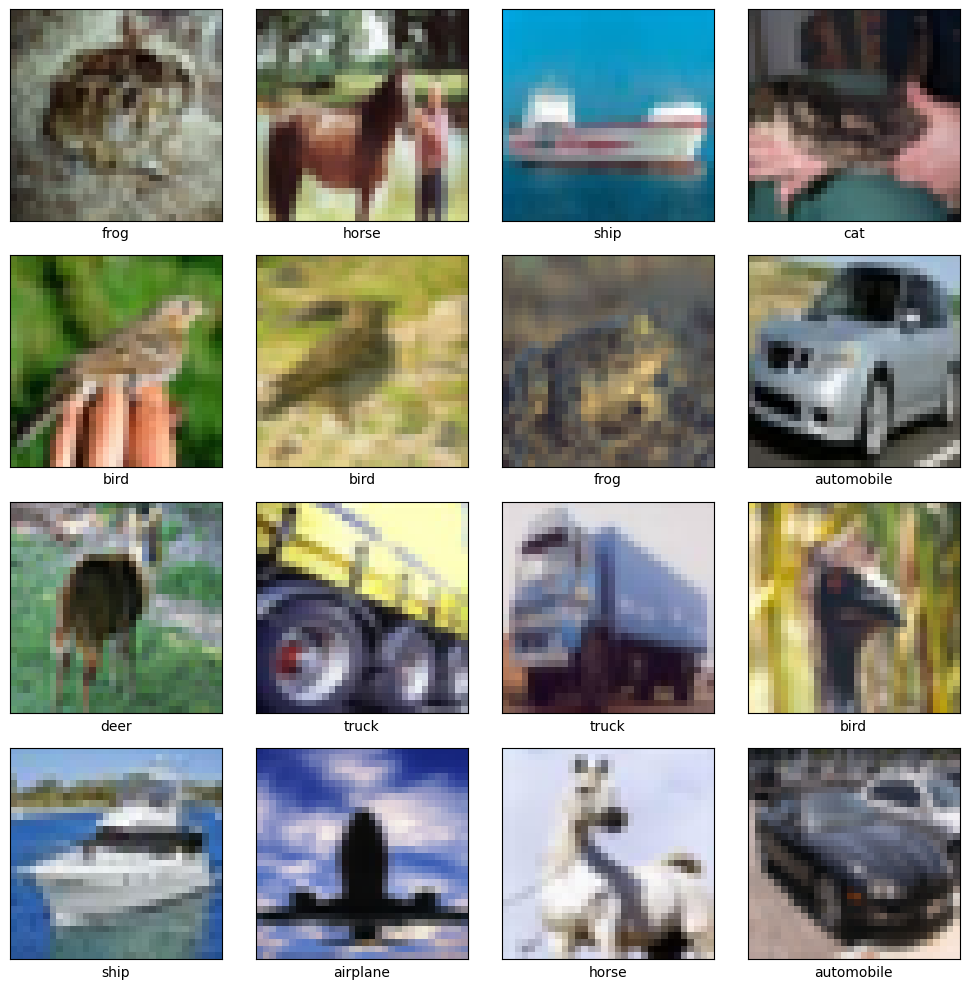

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


# show 16 sample images with labels
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = x_train[i]
    plt.imshow(img)

    #label_idx = int(y_train[i][0])
    label_idx = int(np.squeeze(y_train[i]))

    plt.xlabel(class_names[label_idx])

plt.tight_layout()
plt.show()


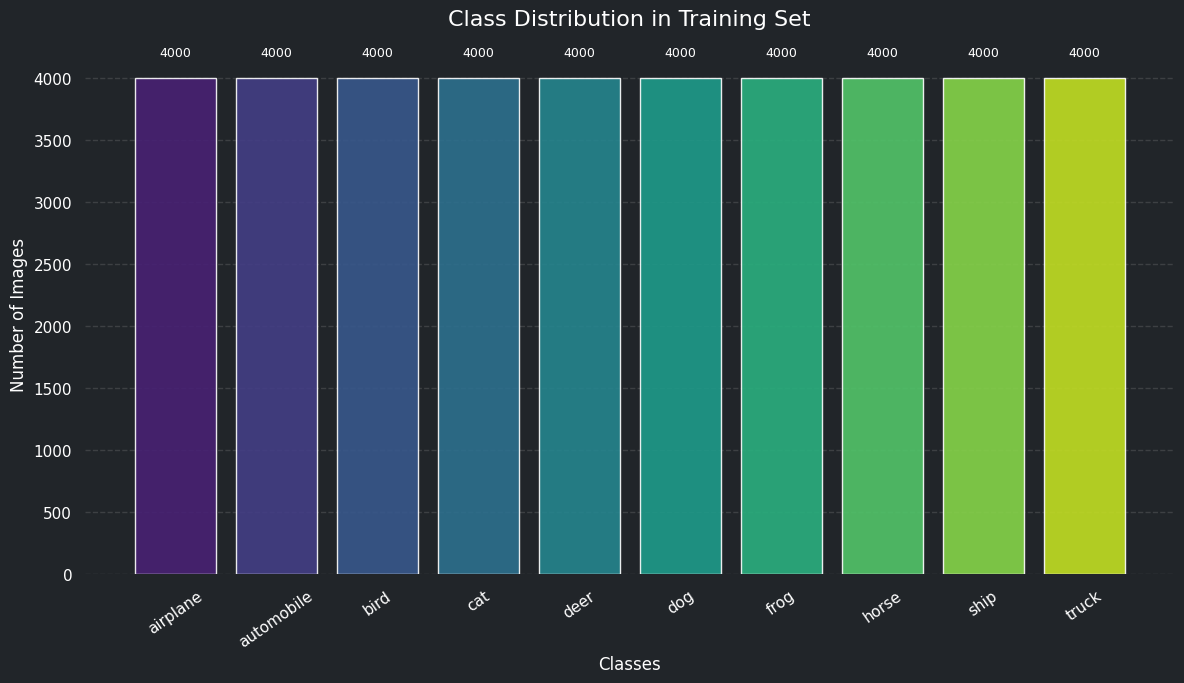

In [5]:
# class distribution (train set)

sns.set_theme(style="dark")
colors = sns.color_palette("viridis", n_colors=10)

fig, ax = plt.subplots(figsize=(12, 7))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')

# calcular distribuição de classes no y_train
unique, counts = np.unique(y_train, return_counts=True)
data_counts = dict(zip(unique.flatten(), counts))

classes = [class_names[i] for i in range(10)]
values = [data_counts[i] for i in range(10)]

ax.bar(classes, values, color=colors, alpha=0.9)

for i, v in enumerate(values):
    ax.text(i, v + 150, str(v), ha='center', va='bottom', color='white', fontsize=9)

ax.set_title('Class Distribution in Training Set', color='white', fontsize=16, pad=20)
ax.set_xlabel('Classes', color='white', fontsize=12)
ax.set_ylabel('Number of Images', color='white', fontsize=12)
ax.tick_params(axis='x', rotation=35, colors='white')
ax.tick_params(axis='y', colors='white')

for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis='y', linestyle='--', alpha=0.3, color='gray')
plt.tight_layout()
plt.show()


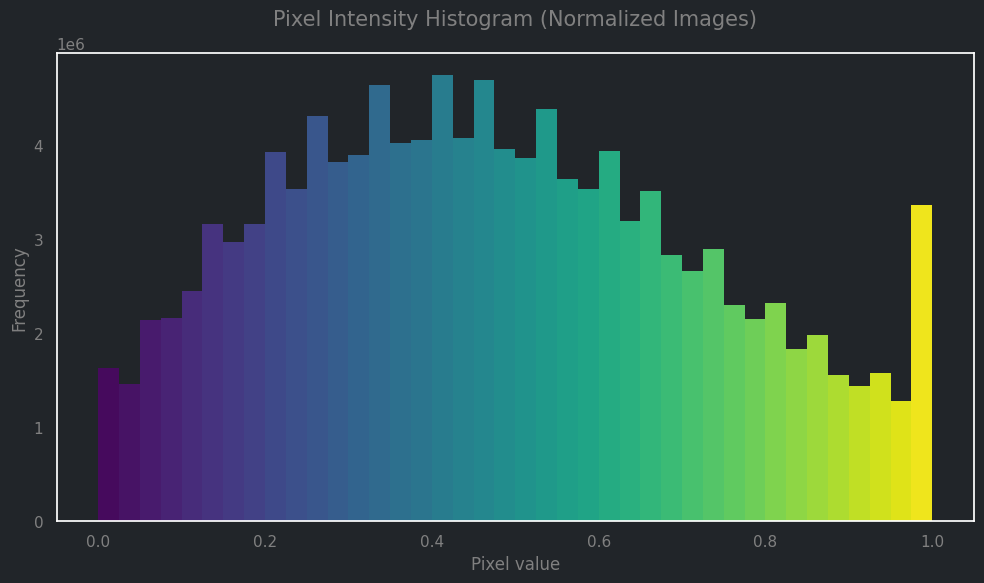

In [6]:
# pixel intensity histogram (train set)

sns.set_theme(style="dark")
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('#212529')
ax.set_facecolor('#212529')

values = x_train.flatten()
bins = 40
counts, bin_edges = np.histogram(values, bins=bins)

# criar uma paleta e aplicar cor diferente por bin
colors = sns.color_palette("viridis", n_colors=bins)

for i in range(bins):
    ax.bar(
        (bin_edges[i] + bin_edges[i+1]) / 2,
        counts[i],
        width=(bin_edges[i+1] - bin_edges[i]),
        color=colors[i],
        align="center",
        edgecolor='none',
        linewidth=0
    )

ax.tick_params(colors='grey')
ax.xaxis.label.set_color('grey')
ax.yaxis.label.set_color('grey')
ax.title.set_color('grey')

plt.title('Pixel Intensity Histogram (Normalized Images)', fontsize=15, pad=20)
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()




In [7]:
processed_dir = "../data/processed"
os.makedirs(processed_dir, exist_ok=True)

np.savez_compressed(
    os.path.join(processed_dir, "cifar10_processed.npz"),
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    x_test=x_test,
    y_test=y_test,
)